## Life Expectancy Analysis and Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geodatasets import get_path
import matplotlib.patches as mpatches

# Statistical and Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind, pearsonr
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [2]:
def load_and_preprocess_data(filepath):
    """
    Load and preprocess the dataset.

    Parameters:
    - filepath (str): The path to the CSV file containing the dataset.

    Returns:
    - df (pd.DataFrame): The loaded and preprocessed DataFrame.
    """
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Ensure correct data types
    df['Year'] = df['Year'].astype(int)
    df['Country'] = df['Country'].astype(str)
    df['Region'] = df['Region'].astype(str)
    
    # Check for missing values
    print("Missing values in each column before imputation:")
    print(df.isnull().sum())
    
    # Since the dataset is already cleaned according to the Kaggle source, we proceed
    return df

In [3]:
def feature_engineering(df):
    """
    Perform feature engineering on the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to process.

    Returns:
    - df (pd.DataFrame): The DataFrame after feature engineering.
    """
    # Combine economic status into a single variable
    df['Economic_Status'] = df.apply(
        lambda row: 'Developed' if row['Economy_status_Developed'] == 1 else 'Developing', axis=1
    )
    df.drop(['Economy_status_Developed', 'Economy_status_Developing'], axis=1, inplace=True)
    
    # Create average immunization score
    immunization_cols = ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria']
    df['Avg_Immunization'] = df[immunization_cols].mean(axis=1)
    
    # Create mortality ratio
    df['Adult_to_Infant_Mortality_Ratio'] = df['Adult_mortality'] / (df['Infant_deaths'] + 1)
    
    # Log transformation of GDP per capita
    df['GDP_per_capita_log'] = np.log(df['GDP_per_capita'] + 1)
    
    # Combine thinness variables
    thinness_cols = ['Thinness_ten_nineteen_years', 'Thinness_five_nine_years']
    df['Thinness_children_adolescents'] = df[thinness_cols].mean(axis=1)
    
    # Combine infant and under-five deaths
    df['Child_deaths'] = df['Infant_deaths'] + df['Under_five_deaths']
    
    # Drop redundant columns
    df.drop(immunization_cols + ['GDP_per_capita'] + thinness_cols + ['Infant_deaths', 'Under_five_deaths'], axis=1, inplace=True)
    
    # One-hot encode 'Economic_Status'
    df = pd.get_dummies(df, columns=['Economic_Status'], drop_first=True)
    
    return df

In [4]:
def calculate_vifs(df, target_variable):
    """
    Calculate Variance Inflation Factors (VIFs) for numerical features.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the features.
    - target_variable (str): The name of the target variable to exclude from VIF calculation.

    Returns:
    - vif_data (pd.DataFrame): DataFrame containing features and their VIF values.
    """
    features = df.select_dtypes(include=[np.number]).columns.tolist()
    features.remove(target_variable)
    X = df[features]
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    print("\nVIF values:")
    print(vif_data)
    return vif_data

In [ ]:
def exploratory_data_analysis(df):
    """
    Perform exploratory data analysis on the DataFrame, including descriptive statistics and visualizations.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    - None
    """
    # Descriptive statistics
    print(df.describe())
    
    # Distribution of Life Expectancy
    plt.figure(figsize=(10,6))
    sns.histplot(df['Life_expectancy'], bins=30, kde=True)
    plt.title('Distribution of Life Expectancy')
    plt.xlabel('Life Expectancy')
    plt.ylabel('Frequency')
    plt.show()
    
    # Life Expectancy Over Years
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)
    plt.title('Average Life Expectancy Over Years')
    plt.xlabel('Year')
    plt.ylabel('Life Expectancy')
    plt.show()
    
    # Life Expectancy by Economic Status
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Economic_Status_Developing', y='Life_expectancy', data=df)
    plt.title('Life Expectancy by Economic Status')
    plt.xlabel('Developing?')
    plt.ylabel('Life Expectancy')
    plt.show()
    
    # Correlation Matrix
    plt.figure(figsize=(16,12))
    numeric_df = df.select_dtypes(include=[np.number]) 
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

In [6]:
def regression_analysis(df):
    """
    Perform regression analysis on the DataFrame using Linear Regression, Ridge, and Lasso models.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - models (tuple): A tuple containing the trained Linear Regression, Ridge, and Lasso models.
    """
    # Define target and features
    X = df.drop(['Life_expectancy', 'Country', 'Region'], axis=1)
    y = df['Life_expectancy']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Multiple Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Coefficients
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lr.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    print("Linear Regression Coefficients:")
    print(coefficients)
    
    # Evaluation
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print('\nLinear Regression RMSE:', rmse)
    print('Linear Regression R^2:', r2)
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)
    print('\nRidge Regression RMSE:', rmse_ridge)
    print('Ridge Regression R^2:', r2_ridge)
    
    # Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)
    print('\nLasso Regression RMSE:', rmse_lasso)
    print('Lasso Regression R^2:', r2_lasso)
    
    return lr, ridge, lasso

In [7]:
def classification_analysis(df):
    """
    Perform classification analysis on the DataFrame using Logistic Regression and Random Forest Classifier.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    - models (tuple): A tuple containing the trained Logistic Regression and Random Forest models.
    """
    # Prepare data
    X_cls = df.drop(['Economic_Status_Developing', 'Country', 'Region'], axis=1)
    y_cls = df['Economic_Status_Developing']
    
    # Split data
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train_cls, y_train_cls)
    y_pred_cls = logreg.predict(X_test_cls)
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test_cls, y_pred_cls))
    
    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_cls, y_train_cls)
    y_pred_rf = rf.predict(X_test_cls)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test_cls, y_pred_rf))
    
    # Feature Importances
    importances = rf.feature_importances_
    feature_names = X_train_cls.columns
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(feature_importances)
    
    return logreg, rf

In [8]:
def arima_forecasting(df, country_name, arima_order=(3, 1, 0), start_year=2016, end_year=2040):
    """
    Perform time series forecasting using ARIMA for a specific country.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - country_name (str): The name of the country to forecast.
    - arima_order (tuple): The (p,d,q) order of the ARIMA model. Default is (3,1,0).
    - start_year (int): The starting year for the forecast. Default is 2016.
    - end_year (int): The ending year for the forecast. Default is 2040.

    Returns:
    - None
    """
    country_data = df[df['Country'] == country_name].groupby('Year')['Life_expectancy'].mean()
    forecast_years = list(range(start_year, end_year + 1))
    
    try:
        arima_model = ARIMA(country_data, order=arima_order)
        arima_results = arima_model.fit()
        forecast = arima_results.get_forecast(steps=len(forecast_years))
        forecast_values = forecast.predicted_mean
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(country_data.index, country_data.values, label="Historical Data", color="blue", marker='o')
        plt.plot(forecast_years, forecast_values, label="Forecasted Data", color="orange", linestyle='--', marker='x')
        plt.title(f"Life Expectancy Forecast for {country_name}")
        plt.xlabel("Year")
        plt.ylabel("Life Expectancy")
        plt.legend()
        plt.grid()
        plt.show()
        
    except Exception as e:
        print(f"ARIMA model failed for {country_name}: {e}")

In [9]:
def xgboost_forecasting(df, country_name, lag=9, start_year=2016, end_year=2040):
    """
    Perform time series forecasting using XGBoost for a specific country.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - country_name (str): The name of the country to forecast.
    - lag (int): The number of lagged observations to use. Default is 9.
    - start_year (int): The starting year for the forecast. Default is 2016.
    - end_year (int): The ending year for the forecast. Default is 2040.

    Returns:
    - None
    """
    # Prepare data with lag features
    data = df.copy()
    features = []
    for i in range(1, lag + 1):
        data[f"Lag_{i}"] = data.groupby('Country')['Life_expectancy'].shift(i)
        features.append(f"Lag_{i}")
    data = data.dropna().reset_index(drop=True)
    
    # Prepare dataset
    X = data[features]
    y = data['Life_expectancy']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Train XGBoost model
    xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Forecasting
    country_data = df[df['Country'] == country_name].sort_values('Year')
    last_values = country_data.tail(lag)['Life_expectancy'].values.tolist()
    forecasts = []
    for _ in range(start_year, end_year + 1):
        input_data = np.array(last_values[-lag:]).reshape(1, -1)
        pred = xgb_model.predict(input_data)[0]
        forecasts.append(pred)
        last_values.append(pred)
    
    # Plotting
    forecast_years = list(range(start_year, end_year + 1))
    historical_data = country_data[country_data['Year'] < start_year]
    plt.figure(figsize=(10, 6))
    plt.plot(historical_data['Year'], historical_data['Life_expectancy'], label="Historical Data", color="blue", marker='o')
    plt.plot(forecast_years, forecasts, label="Forecasted Data", color="orange", linestyle='--', marker='x')
    plt.title(f"Life Expectancy Forecast for {country_name}")
    plt.xlabel("Year")
    plt.ylabel("Life Expectancy")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
def clustering_analysis(df, n_clusters=3, cluster_labels=None):
    """
    Perform clustering analysis on the DataFrame using K-Means clustering.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - n_clusters (int): The number of clusters to form. Default is 3.
    - cluster_labels (dict): A dictionary mapping cluster numbers to labels. Default is None.

    Returns:
    - df (pd.DataFrame): The DataFrame with cluster assignments.
    """
    if cluster_labels is None:
        cluster_labels = {i: f'Cluster {i}' for i in range(n_clusters)}
    
    X = df.drop(['Life_expectancy', 'Country', 'Region'], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    df['Cluster'] = clusters

    # Map cluster numbers to labels
    df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

    # Define the color palette based on the labels
    unique_labels = df['Cluster_Label'].unique()
    colors = sns.color_palette('hsv', len(unique_labels))
    color_map = dict(zip(unique_labels, colors))

    # Plot clusters with the specified color palette
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster_Label'], palette=color_map, s=100)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Country Clustering")
    plt.legend(title='Cluster Label')
    plt.show()
    
    # Load world shapefile
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Merge world map with data
    world = world.merge(df[['Country', 'Cluster_Label']].drop_duplicates(), left_on='name', right_on='Country', how='left')

    # Fill missing values
    world['Cluster_Label'].fillna('Unknown', inplace=True)

    # Update color map
    unique_labels = world['Cluster_Label'].unique()
    colors = sns.color_palette('hsv', len(unique_labels))
    color_map = dict(zip(unique_labels, colors))

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.plot(ax=ax, color=world['Cluster_Label'].map(color_map), edgecolor='black', legend=False)

    # Add the legend manually
    handles = [mpatches.Patch(color=color_map[label], label=label) for label in color_map]
    ax.legend(handles=handles, title="Cluster Label", fontsize=12)

    # Add title
    ax.set_title("Country Clusters by Development Status", fontsize=15)

    # Show the plot
    plt.show()
    
    return df

In [11]:
def main():
    """
    Main function to run all analyses.
    """
    # Parameters
    data_filepath = 'Life-Expectancy-Data-Updated.csv'
    cleaned_data_filepath = 'Cleaned_Life_Expectancy_Data.csv'
    countries_to_forecast = ['Argentina', 'United States']
    arima_order = (3, 1, 0)
    start_year = 2016
    end_year = 2040
    n_clusters = 3
    cluster_labels = {0: 'Emerging', 1: 'Developing', 2: 'Developed'}
    
    # Load and preprocess data
    df = load_and_preprocess_data(data_filepath)
    
    # Feature engineering
    df = feature_engineering(df)
    
    # Calculate VIFs
    vif_data = calculate_vifs(df, 'Life_expectancy')
    
    # Save the cleaned and prepared dataset
    df.to_csv(cleaned_data_filepath, index=False)
    print(f"\nData cleaning and feature engineering complete. Cleaned data saved to '{cleaned_data_filepath}'.")
    
    # Exploratory Data Analysis
    exploratory_data_analysis(df)
    
    # Regression Analysis
    regression_models = regression_analysis(df)
    
    # Classification Analysis
    classification_models = classification_analysis(df)
    
    # ARIMA Forecasting
    for country in countries_to_forecast:
        arima_forecasting(df, country_name=country, arima_order=arima_order, start_year=start_year, end_year=end_year)
    
    # XGBoost Forecasting
    for country in countries_to_forecast:
        xgboost_forecasting(df, country_name=country, start_year=start_year, end_year=end_year)
    
    # Clustering Analysis
    df_clustered = clustering_analysis(df, n_clusters=n_clusters, cluster_labels=cluster_labels)
    
    # Additional statistical tests
    # Pearson Correlation
    correlation, _ = pearsonr(df['Child_deaths'], df['Life_expectancy'])
    print(f"\nPearson Correlation between Child Deaths and Life Expectancy: {correlation:.4f}")
    
    # t-test between Developed and Developing countries
    developed = df[df['Economic_Status_Developing'] == 0]['Life_expectancy']
    developing = df[df['Economic_Status_Developing'] == 1]['Life_expectancy']
    t_stat, p_value = ttest_ind(developed, developing)
    print(f"\nt-test between Developed and Developing countries: t={t_stat:.4f}, p={p_value:.4f}")

Missing values in each column before imputation:
Country                        0
Region                         0
Year                           0
Infant_deaths                  0
Under_five_deaths              0
Adult_mortality                0
Alcohol_consumption            0
Hepatitis_B                    0
Measles                        0
BMI                            0
Polio                          0
Diphtheria                     0
Incidents_HIV                  0
GDP_per_capita                 0
Population_mln                 0
Thinness_ten_nineteen_years    0
Thinness_five_nine_years       0
Schooling                      0
Economy_status_Developed       0
Economy_status_Developing      0
Life_expectancy                0
dtype: int64

VIF values:
                            Feature         VIF
0                              Year  637.956691
1                   Adult_mortality   33.011965
2               Alcohol_consumption    6.165329
3                               BMI  345

c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


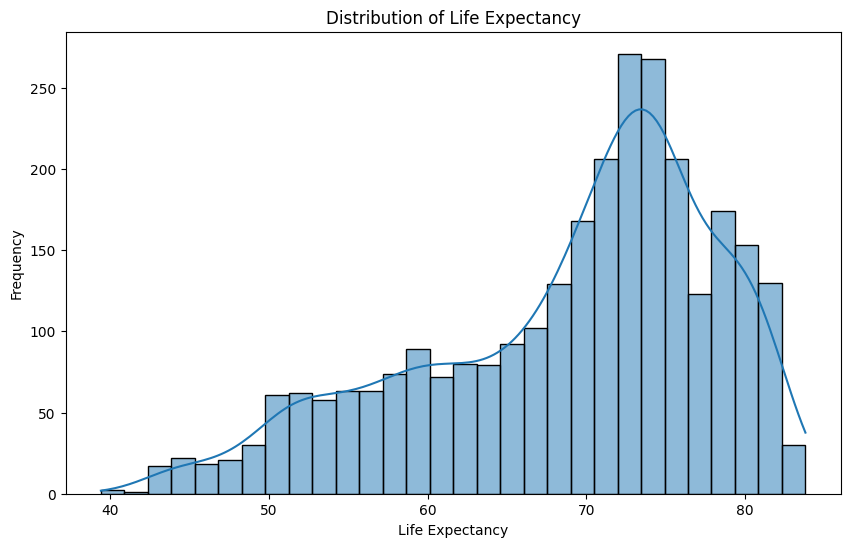

C:\Users\sabme\AppData\Local\Temp\ipykernel_7404\1335124606.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Life_expectancy', ci=None)
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sabme\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


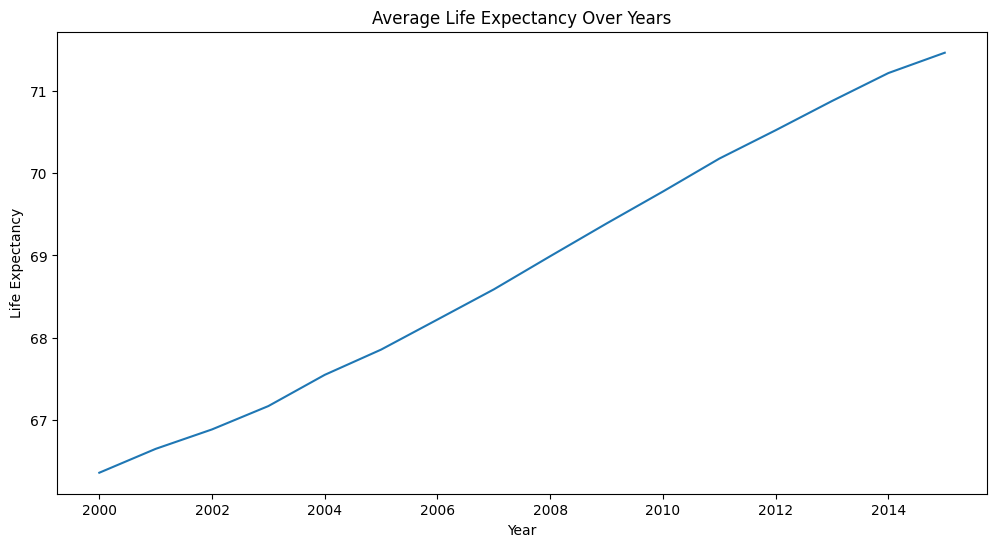

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticks'

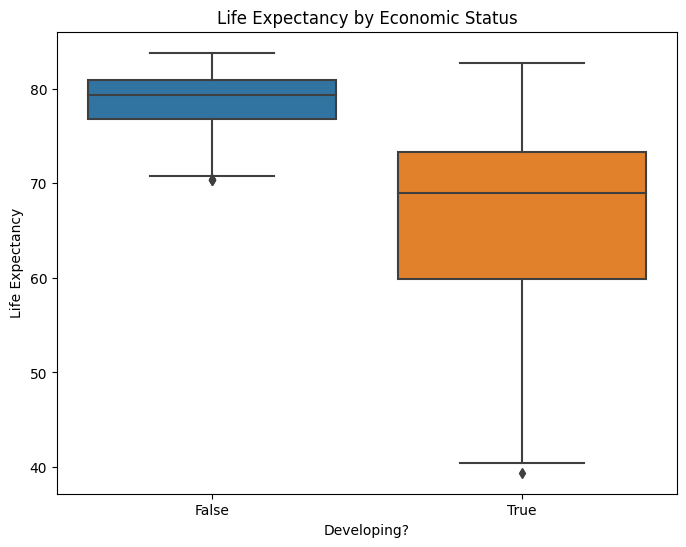

In [12]:
# Run the main function
if __name__ == "__main__":
    main()